In [24]:
import requests
import json
import matplotlib.pyplot as plt
import numpy as np

from data import Data

import utils

# 팀전 승리, 패배 예측 시스템
팀전 경기에 참여하는 플레이어들의 닉네임을 입력으로 받아, 우리 팀과 상대 팀의 평균적인 전력을 비교합니다.
위 예측 시스템은 아래와 같은 방법으로 구현됩니다.  

1. 플레이어의 닉네임을 입력으로 받은 후, utils.get_matchlist 함수를 통해 최근 1년간의 스피드 개인전에서 기록한 상대 순위 정보를 가져옵니다.  
(상대 순위란, 자신의 순위/총 플레이어 수 를 의미합니다)
2. 현재 매치에 참여하는 플레이어들의 평균 상대 순위를 각각 계산합니다.
3. 2번의 결과를 기준으로 8명의 예상 순위를 나열한 후, 순위를 기준으로 예상 획득 포인트 계산 및 승리 팀을 예측합니다.

## 순위 정보 가져오기

플레이어들의 최근 순위를 가져옵니다.  
우선 utils.get_matchlist() 함수를 통해 utils.Match() 객체를 원소로 갖는 matchlist를 가져온 후, matchlist에서 각 Match에서의 플레이어의 순위 정보를 불러와 저장합니다.

이때 8명 모두가 참여한 경기만을 대상에 포함하며, 모드는 스피드 개인전으로 한정합니다. 리타이어한 경기는 반영하지 않습니다.  
경기는 최근 1년까지의 기록만을 포함하며, 최대 최근 500경기까지만을 반영 가능합니다.  

여기에서는 아래의 라이더명을 예시로 사용합니다. 1 ~ 4번은 레드 팀, 5 ~ 8번은 블루 팀이 됩니다.
1. 핑퐁듀
2. MysTic벤츠
3. MOOOMOO (여담이지만, 저입니다)
4. TwitchTV
---
5. MusicTherapy
6. 개뛰는일영
7. 폴창
8. 에퍼한상현

우선 플레이어의 닉네임을 토대로, 모든 플레이어의 account number (플레이어 고유번호) 를 가져옵니다.

In [25]:
team_red = ['핑퐁듀', 'MysTic벤츠' , 'MOOOMOO', 'TwitchTV' ]
team_blue = ['MusicTherapy', '개뛰는일영', '폴창' ,'에퍼한상현']
nicknames = team_red + team_blue
print(nicknames)
accountNos = []

for nickname in nicknames:
    userinfo = utils.get_user_by_nickName(nickname) # nickname을 통해 utils.User 인스턴스 형태의 유저 정보를 가져옵니다
    accountNos.append(userinfo.accountNo) # 각 User에서 accessId를 추출합니다.

['핑퐁듀', 'MysTic벤츠', 'MOOOMOO', 'TwitchTV', 'MusicTherapy', '개뛰는일영', '폴창', '에퍼한상현']
{'accessId': '822340476', 'name': '핑퐁듀', 'level': 108}
{'accessId': '218381982', 'name': 'MysTic벤츠', 'level': 108}
{'accessId': '973305538', 'name': 'MOOOMOO', 'level': 108}
{'accessId': '1057200556', 'name': 'TwitchTV', 'level': 108}
{'accessId': '268936929', 'name': 'MusicTherapy', 'level': 108}
{'accessId': '50967590', 'name': '개뛰는일영', 'level': 108}
{'accessId': '553901562', 'name': '폴창', 'level': 108}
{'accessId': '855952487', 'name': '에퍼한상현', 'level': 108}


In [26]:
accountNos

['822340476',
 '218381982',
 '973305538',
 '1057200556',
 '268936929',
 '50967590',
 '553901562',
 '855952487']

위에서 구한 accountNo를 토대로, 8명의 플레이어에 대한 최근 매치리스트를 추출합니다. 사용되는 함수는 utils.get_matchlist입니다.
매치리스트는 utils.Match 객체들로 이루어진 list를 의미하며, 매치들에 대한 정보들이 담겨 있습니다.

In [27]:
# all_matchlists : list[list], 모든 플레이어들의 matchlist를 저장
all_matchlists : list = []

for accountNo in accountNos:
    matchlist = utils.get_matchlist(
        accountNo = accountNo, startTime = '', endTime = '', # startTime, endTime을 따로 지정하지 않는 경우, 자동으로 최근 500건의 매치를 받아옵니다.
        matchType='7b9f0fd5377c38514dbb78ebe63ac6c3b81009d5a31dd569d1cff8f005aa881a' # matchType : 스피드 개인전으로 한정
        )
    all_matchlists.append(matchlist) # 각 플레이어의 matchlist를 all_matchlists에 추가합니다.

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


위의 all_matchlists에서 각 플레이어의 순위 정보를 추출해 저장합니다.  
이때 n_players를 통해 포함하고자 하는 총 플레이어의 수를 지정합니다 (여기서는 8명이 참여한 경기만 포함).  
또한 리타이어는 포함하지 않습니다.

In [28]:
# all_ranks = list[list], 모든 플레이어들의 ranks를 저장
all_ranks = []

for matchlist in all_matchlists:
    ranks : list = utils.get_ranks(matchlist, n_players = [8], include_retire=False)
    all_ranks.append(ranks)

In [29]:
# all_ranks[0]

## 시각화
꼭 필요한 과정은 아니지만, utils.bar_ranks() 함수를 이용하여 상대순위의 변화 그래프를 그릴 수 있습니다.

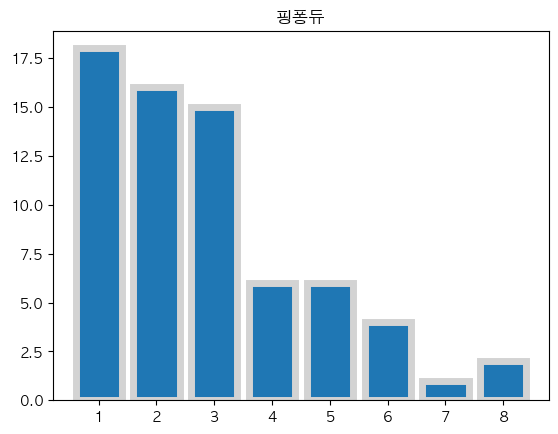

In [30]:
utils.bar_ranks(all_ranks[0], nicknames[0], n_players=8)

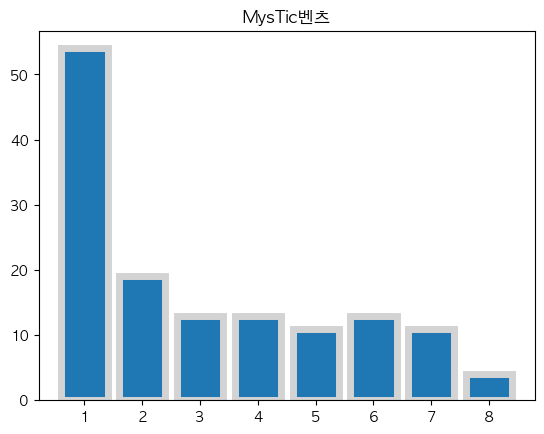

In [31]:
utils.bar_ranks(all_ranks[1], nicknames[1], n_players=8) # 여담으로, 이분은 (준)프로 출신입니다.

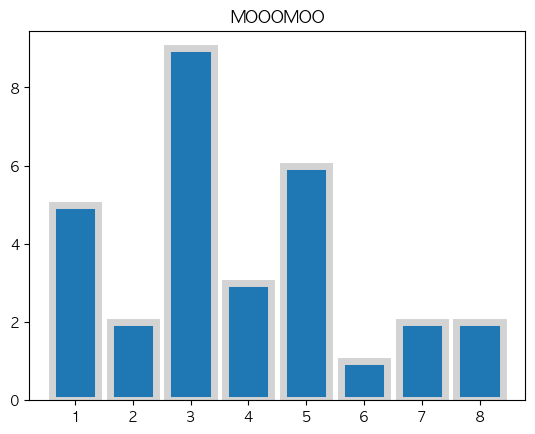

In [32]:
utils.bar_ranks(all_ranks[2], nicknames[2], n_players=8) # 생각보다 잘 못했다 나...

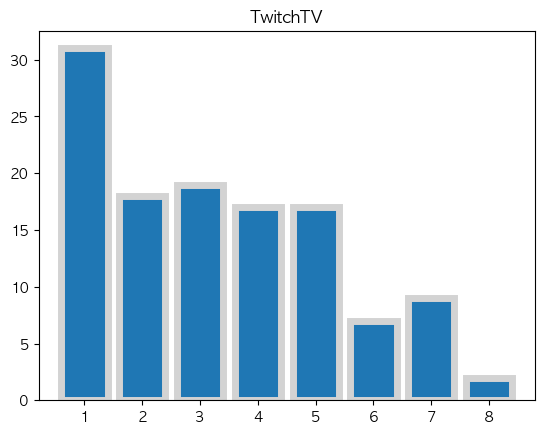

In [33]:
utils.bar_ranks(all_ranks[3], nicknames[3], n_players=8)

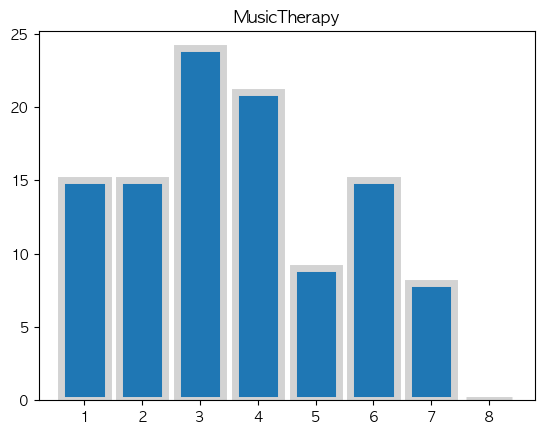

In [34]:
utils.bar_ranks(all_ranks[4], nicknames[4], n_players=8)

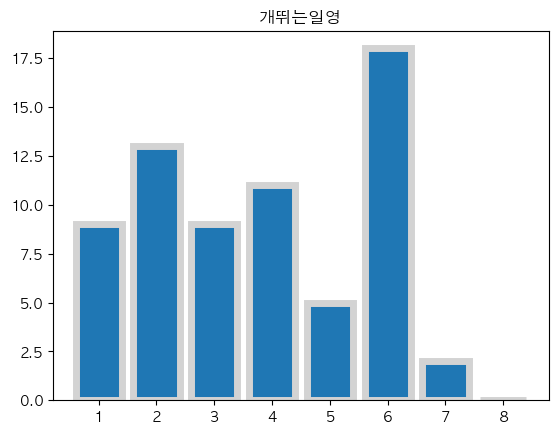

In [35]:
utils.bar_ranks(all_ranks[5], nicknames[5], n_players=8)

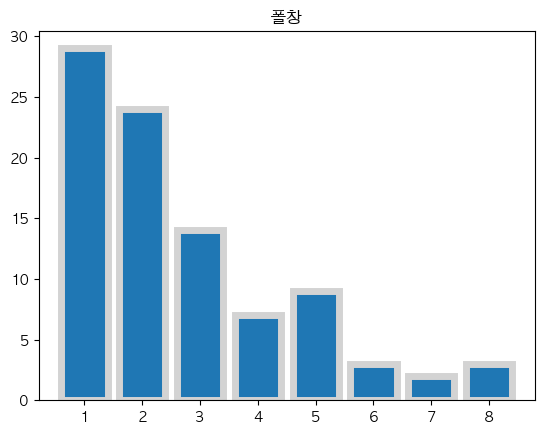

In [36]:
utils.bar_ranks(all_ranks[6], nicknames[6], n_players=8)

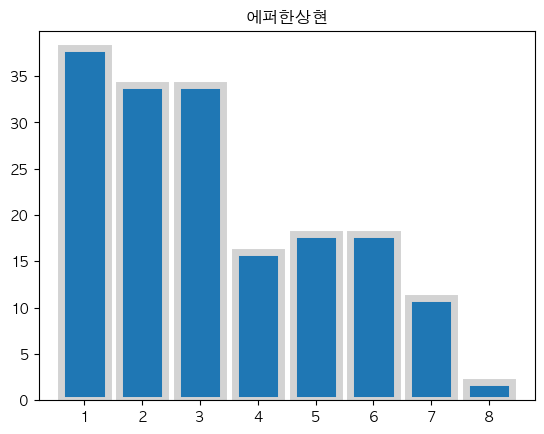

In [37]:
utils.bar_ranks(all_ranks[7], nicknames[7], n_players=8)

## 평균 등수 정보 계산
각 플레이어의 평균 등수 정보를 계산합니다.

In [38]:
avg_ranks = []

for ranks in all_ranks:
    avg_rank = round(sum(ranks) / len(ranks), 2)
    avg_ranks.append(avg_rank)

In [39]:
avg_ranks

[2.88, 3.08, 3.8, 3.32, 3.66, 3.78, 2.73, 3.29]

위의 평균 순위를 토대로, 예상 순위를 나열합니다 (리타이어는 고려하지 않습니다).
우선 avg_ranks에서 값이 작은 순서대로 인덱스를 구한 후, 해당 인덱스 위치에 있는 라이더명을 가져옵니다.

In [40]:
sorted_indexes = sorted(range(len(avg_ranks)), key=lambda k: avg_ranks[k], reverse=True)[::-1]
sorted_indexes


[6, 0, 1, 7, 3, 4, 5, 2]

In [41]:
# nicknames = ['핑퐁듀', 'MysTic벤츠', 'MOOOMOO', 'TwitchTV', 'MusicTherapy', '개뛰는일영', '폴창', '에퍼한상현']
sorted_nicknames = ['' for i in range(8)]

for i in range(8):
    sorted_nicknames[i] = nicknames[sorted_indexes[i]]
    
sorted_nicknames # 닉네임을 평균순위 순서대로 정렬

['폴창',
 '핑퐁듀',
 'MysTic벤츠',
 '에퍼한상현',
 'TwitchTV',
 'MusicTherapy',
 '개뛰는일영',
 'MOOOMOO']

위의 결과를 토대로, 팀전에서의 예상 순위와 예상 획득 포인트를 계산합니다. 카트라이더 팀전에서의 등수별 포인트는 아래와 같습니다.  

1위 : 10  
2위 : 8  
3위 : 6  
4위 : 5  
5위 : 4  
6위 : 3  
7위 : 2  
8위 : 1  

아래는 예상 결과를 시각화하는 코드입니다.

## 예상 결과 계산 및 시각화

In [42]:
# team_red = ['핑퐁듀', 'MysTic벤츠' , 'MOOOMOO', 'TwitchTV' ]
# team_blue = ['MusicTherapy', '개뛰는일영', '폴창' ,'에퍼한상현']
# sorted_nicknames = ['폴창','핑퐁듀','MysTic벤츠','에퍼한상현','TwitchTV','MusicTherapy','개뛰는일영','MOOOMOO']

points = [10, 8, 6, 5, 4, 3, 2, 1] # 순위에 따른 획득 포인트 기준
red_result = {}
blue_result = {}

for i in range(8):
    if sorted_nicknames[i] in team_red:
        red_result[sorted_nicknames[i]] = points[i]
    else:
        blue_result[sorted_nicknames[i]] = points[i]

In [43]:
red_result

{'핑퐁듀': 8, 'MysTic벤츠': 6, 'TwitchTV': 4, 'MOOOMOO': 1}

In [44]:
blue_result

{'폴창': 10, '에퍼한상현': 5, 'MusicTherapy': 3, '개뛰는일영': 2}

Text(0.5, 1.0, 'Blue')

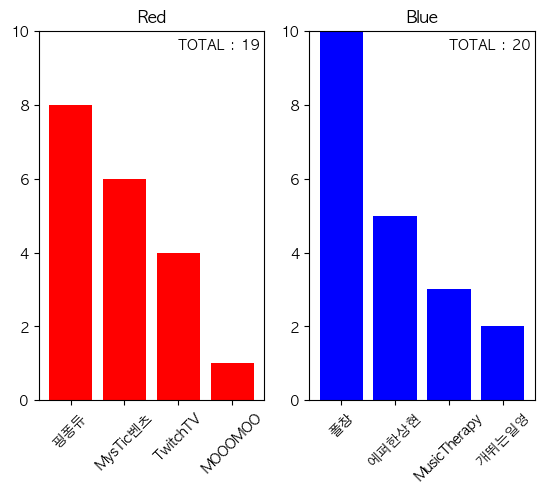

In [45]:
red_X = red_result.keys()
red_y = red_result.values()

blue_X = blue_result.keys()
blue_y = blue_result.values()

red_total = sum(list(red_result.values()))
blue_total = sum(list(blue_result.values()))

plt.figure()

plt.subplot(1, 2, 1)
plt.bar(red_X, red_y, align='center', color = 'r')
plt.ylim(0, 10)
plt.xticks(rotation = 45)
plt.text(2, 9.5, f'TOTAL : {red_total}')
plt.title('Red')

plt.subplot(1, 2, 2)
plt.bar(blue_X, blue_y, align='center', color = 'b')
plt.xticks(rotation = 45)
plt.ylim(0, 10)
plt.text(2, 9.5, f'TOTAL : {blue_total}')
plt.title('Blue')